In [1]:
import pickle
import datetime
from dateutil.parser import parse

import pandas as pd

In [2]:
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#nltk.download()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [3]:
# read data from pickle file
with open ('all_data.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [24]:
# take a subset of dataset to try things out
#df2 = df[(df['date'] < datetime.date(2016,11,1))]
#df2 = df.sample(n=10000)
df.dropna(inplace=True)
df2 = df.copy()
#df2.drop(df2['date'] == datetime.date(2016,12,22))

#df2 = df2.drop(df2[df2.date == datetime.date(2016,12,22)].index)

df2.columns

Index(['date', 'headline', 'snippet'], dtype='object')

In [5]:
df2[df2.date == datetime.date(2016,12,22)]

,date,headline,snippet
14918,2016-12-22,Gentrification and Junk Food: Chopped-Cheese E...,It is hard to know when or how much to get exe...
14919,2016-12-22,Ivan Nova Is Said to Agree to 3-Year Deal to S...,Nova struck out 52 batters and walked just thr...
14920,2016-12-22,London Plane: A Tree With Gritty Roots,This tree has shown itself to be an urban surv...
14921,2016-12-22,New Ebola Vaccine Gives 100 Percent Protection,"After decades of trying, scientists have final..."
14922,2016-12-22,"At Rudy’s Bakery and Cafe, Venturing Beyond th...",The soda-shop signage and décor at the Ridgewo...
14923,2016-12-22,The Best Poetry of 2016,The Book Review’s On Poetry columnist picks hi...
14924,2016-12-22,What Happens to Food Seized at the Airport?,"No matter how tempting, these items are not co..."
14925,2016-12-22,"How Poppy King, Founder of Lipstick Queen, Spe...",The 44-year-old founder of the cosmetics brand...
14926,2016-12-22,Peter Berg Narrates a Scene From ‘Patriots Day’,The director discusses a sequence from his fil...
14927,2016-12-22,Carolina Herrera and Oscar de la Renta Clash O...,The two fashion houses are engaged in a drama-...


In [28]:
#df2['head_snip'] = df2['headline'].add(df2.snippet)
df2['head_snip'] = df['headline'] + ' '+ df['snippet']
df2.shape

(124143, 4)

In [25]:
tf_vectorizer = CountVectorizer(
            max_df = 0.95, # leave out words that occur in more than 95% of docs
            min_df = 2,    # leave out if occurs less than twice
            ngram_range=(1,3),
            stop_words='english')
#tf_vectorizer.fit(df2.headline)
tf_vectorizer.fit(df2.snippet)
#counts = tf_vectorizer.transform(df2.snippet).transpose()

#tf = tf_vectorizer.fit_transform(df2.snippet)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [ ]:
corpus = matutils.Sparse2Corpus(tf)

In [ ]:
tf_vectorizer.vocabulary_

In [ ]:
id2word = dict((v, k) for k, v in tf_vectorizer.vocabulary_.items())
len(id2word)

In [ ]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, minimum_probability=0.03, id2word=id2word, passes=10)

In [55]:
tf_vectorizer = CountVectorizer(
            max_df = 0.95, # leave out words that occur in more than 95% of docs
            min_df = 2,    # leave out if occurs less than twice
            ngram_range=(1,3),
            stop_words='english')
#tf_vectorizer.fit(df2.snippet)
#counts = tf_vectorizer.transform(df2.snippet).transpose()

dtm_tf = tf_vectorizer.fit_transform(df2.snippet)
print(dtm_tf.shape)

tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df2.snippet)
print(dtm_tfidf.shape)
from sklearn.decomposition import LatentDirichletAllocation
# for TF DTM

lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

AttributeError: 'NoneType' object has no attribute 'lower'

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

no_features = 1000


In [ ]:
type(documents)

## start here

In [29]:
df2.columns

Index(['date', 'headline', 'snippet', 'head_snip'], dtype='object')

In [30]:
documents = list(df2['head_snip'])

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

#documents = list(df2['snippet'])
no_features = 1000


def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print('document with index',doc_index)
            print(documents[doc_index])
        print(' ')

In [35]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                   min_df=2, 
                                   max_features=no_features, 
                                   stop_words='english')
#tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
#tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
#tf = tf_vectorizer.fit_transform(documents)
tf_vectorizer = CountVectorizer(
            max_df = 0.95, # leave out words that occur in more than 95% of docs
            min_df = 2,    # leave out if occurs less than twice
            ngram_range=(1,3),
            stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

KeyboardInterrupt: 

In [38]:
write = True
if write == True:
    # write data to pickle file
    with open('tf_max_df95.pkl', 'wb') as fp:
        pickle.dump(tf, fp)
    with open('tfidf_max_df95.pkl', 'wb') as fp:
        pickle.dump(tfidf, fp)

elif write == False:
    # read data from pickle file
    with open('tf_max_df95.pkl', 'rb') as fp:
        tf = pickle.load(fp)
    with open('tfidf_max_df95.pkl', 'rb') as fp:
        tfidf = pickle.load(fp)


In [83]:
tf

<123957x128311 sparse matrix of type '<class 'numpy.int64'>'
	with 1027121 stored elements in Compressed Sparse Row format>

In [37]:
tfidf_feature_names

['000',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '20',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '24',
 '25',
 '30',
 '50',
 'abuse',
 'accusations',
 'accused',
 'act',
 'action',
 'actor',
 'actress',
 'address',
 'administration',
 'affordable',
 'afghanistan',
 'africa',
 'african',
 'age',
 'agency',
 'agenda',
 'ago',
 'ahead',
 'aid',
 'air',
 'al',
 'album',
 'allegations',
 'amazon',
 'america',
 'american',
 'americans',
 'amid',
 'andrew',
 'angeles',
 'announced',
 'annual',
 'anthony',
 'anti',
 'app',
 'appeared',
 'appearing',
 'apple',
 'approach',
 'april',
 'area',
 'arrested',
 'art',
 'articles',
 'artist',
 'artists',
 'arts',
 'ask',
 'asked',
 'assault',
 'attack',
 'attacks',
 'attention',
 'attorney',
 'australia',
 'australian',
 'author',
 'authorities',
 'avoid',
 'awards',
 'away',
 'bad',
 'ballet',
 'ban',
 'bank',
 'bar',
 'baseball',
 'based',
 'battle',
 'beat',
 'bedroom',
 'began',
 'beijing',
 'best',
 'be

In [ ]:
no_topics = 20

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

In [32]:
no_top_words = 10
no_top_documents = 5
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
new york city times today
document with index 97377
How Do You Move a Shark? Very Carefully Stocking the new shark exhibit at the New York Aquarium involves construction gear, canvas slings and considerable hands-on wrangling.
document with index 97437
What to Pack in Your New York City Survival Kit Items that every New Yorker should considering stashing in their bag, as recommended by your fellow New Yorkers.
document with index 89381
Four Restaurants — Hidden in New York City Basements A new wave of underground bars and dining spaces is catering to our escapist fantasies.
Topic 1:
trump president donald administration mr
document with index 55727
Trump, Neo-Nazis and the Klan Sirens are blaring as President Trump follows the siren song of the basest of his base and crashes against the shoals.
document with index 112460
Trump Implicated A setback for the president. 
document with index 40323
Trump’s Version of Keeping Us Safe We pause while the president feels sorry for himse

new times york new york week
document with index 1850
What We&#8217;re Reading Get recommendations from New York Times reporters and editors, highlighting great stories from around the web. Today, great reads from John Schwartz, Tyson Evans and others....
document with index 8508
What We&#8217;re Reading Get recommendations from New York Times reporters and editors, highlighting great stories from around the web. Today, great reads from John Broder, Nick Kristof and others....
document with index 15139
What We&#8217;re Reading Get recommendations from New York Times reporters and editors, highlighting great stories from around the web. Today, great reads from Randy Archibold, Jan Hoffman and others....
Topic 3:
art korea north fall review
document with index 305
Letters to the Editor Readers respond to recent reviews of Richard Kluger’s “Indelible Ink,” Richard Cohen’s “She Made Me Laugh” and more....
document with index 16
Fashion Week Photo Diary: Christian Dior and Loewe Scenes from

In [ ]:
topic_idx = 4
foo = nmf_W[:,topic_idx]
new_array = foo[np.where(foo != 0.)]
for index in np.argsort(new_array):    
    print(index)
print(len(new_array))


Topic 0:
documents in topic 37327
Topic 1:
documents in topic 37018
Topic 2:
documents in topic 20104
Topic 3:
documents in topic 96928
Topic 4:
documents in topic 21098
Topic 5:
documents in topic 14640
Topic 6:
documents in topic 32429
Topic 7:
documents in topic 12862
Topic 8:
documents in topic 34334
Topic 9:
documents in topic 12969
Topic 10:
documents in topic 15045
Topic 11:
documents in topic 43805
Topic 12:
documents in topic 19524
Topic 13:
documents in topic 22134
Topic 14:
documents in topic 26988
Topic 15:
documents in topic 19693
Topic 16:
documents in topic 15933
Topic 17:
documents in topic 24519
Topic 18:
documents in topic 21543
Topic 19:
documents in topic 35772


[{58: 1228,
  62: 1225,
  64: 1211,
  52: 918,
  40: 1335,
  63: 1301,
  48: 1276,
  67: 1133,
  56: 1206,
  57: 1293,
  39: 360,
  46: 1301,
  59: 1370,
  71: 1331,
  68: 1137,
  72: 1250,
  50: 1174,
  61: 1270,
  53: 1013,
  65: 1222,
  69: 1237,
  70: 1237,
  51: 1075,
  45: 1344,
  42: 1302,
  60: 1165,
  49: 1282,
  44: 1364,
  47: 1036,
  54: 1239,
  43: 1302,
  66: 1275,
  55: 1256,
  41: 1288,
  73: 355},
 {60: 1165,
  47: 1036,
  48: 1276,
  58: 1228,
  40: 1335,
  70: 1237,
  54: 1239,
  50: 1174,
  49: 1282,
  42: 1302,
  61: 1270,
  71: 1331,
  63: 1301,
  66: 1275,
  39: 360,
  45: 1344,
  59: 1370,
  56: 1206,
  57: 1293,
  46: 1301,
  43: 1302,
  67: 1133,
  68: 1137,
  64: 1211,
  53: 1013,
  44: 1364,
  55: 1256,
  65: 1222,
  52: 918,
  62: 1225,
  51: 1075,
  69: 1237,
  41: 1288,
  72: 25},
 {43: 1302,
  40: 1335,
  42: 1302,
  50: 1174,
  44: 1364,
  55: 1256,
  56: 1206,
  54: 1239,
  41: 1288,
  49: 1282,
  48: 1276,
  51: 1075,
  47: 1036,
  53: 1013,
  57: 114

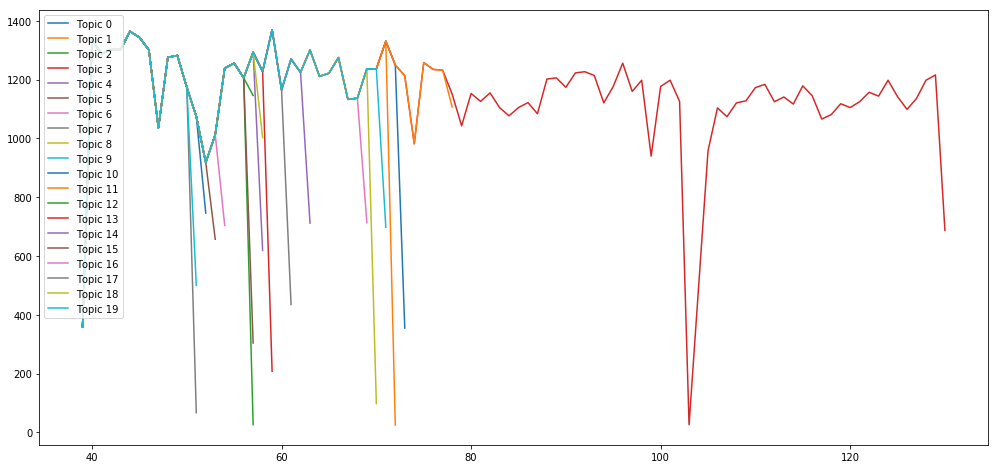

In [34]:
dates = list(df2['date'])
import matplotlib.pyplot as plt



def plot_topic_trend(H, W, feature_names, documents, dates):
    plt.figure(figsize=(17,8))
    plot_data_all = []
    for topic_idx, topic in enumerate(H):
    #for topic_idx in range(0,1):
        count = 0
        print("Topic %d:" % (topic_idx))
        plot_data = {}
        print('documents in topic',len(np.unique(nmf_W[:,topic_idx])))
        foo = nmf_W[:,topic_idx]
        new_array = foo[np.where(foo != 0.)]

        #for doc_index in np.argsort(W[:,topic_idx]):
        for doc_index in np.argsort(new_array):
            #print(doc_index)
            date_key = dates[int(doc_index)]
            year, week, weekday = date_key.isocalendar()
            if year == 2017:
                week += 52
            elif year == 2018:
                week += 104
                
            if week in plot_data:
                plot_data[week] += 1
            else:
                count += 1
                plot_data[week] = 1
                #if count < 10: print(doc_index, dates[doc_index])
        plt.plot(*zip(*sorted(plot_data.items())),label=f'Topic {topic_idx}')
        plot_data_all.append(plot_data)
    plt.legend(loc='upper left');
    return plot_data_all

plot_topic_trend(nmf_H, nmf_W, tfidf_feature_names, documents, dates)
#plot_data_all = plot_topic_trend(nmf_H, nmf_W, tfidf_feature_names, documents, dates)

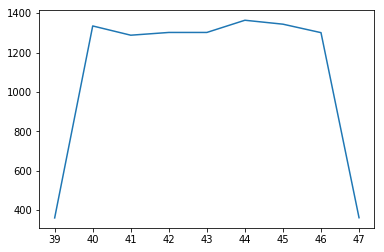

In [75]:
#plt.plot(plot_data_all[:][1])
topic_idx = 3
plot_data_all[:][topic_idx]
plt.plot(*zip(*sorted(plot_data_all[:][topic_idx].items())),label=f'Topic {topic_idx}')


Topic 0:
documents in topic 29971
Topic 1:
documents in topic 18536
Topic 2:
documents in topic 12495
Topic 3:
documents in topic 6741
Topic 4:
documents in topic 1443
Topic 5:
documents in topic 17121
Topic 6:
documents in topic 12188
Topic 7:
documents in topic 2427
Topic 8:
documents in topic 6489
Topic 9:
documents in topic 2258
Topic 10:
documents in topic 7403
Topic 11:
documents in topic 6029
Topic 12:
documents in topic 6591
Topic 13:
documents in topic 4285
Topic 14:
documents in topic 4714
Topic 15:
documents in topic 4262
Topic 16:
documents in topic 2887
Topic 17:
documents in topic 32548
Topic 18:
documents in topic 5966
Topic 19:
documents in topic 9459


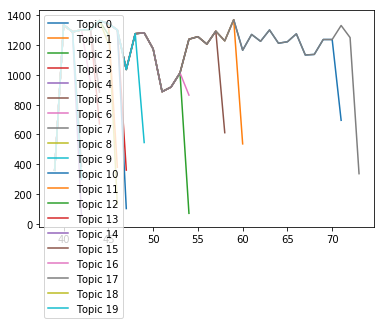

In [61]:
plot_topic_trend(lda_H, lda_W, tf_feature_names, documents, dates)

In [ ]:
import pyLDAvis.gensim
import pyLDAvis.sklearn

import gensim
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)


## using Word2Vect

In [ ]:
import os

# Setup nltk corpora path and Google Word2Vec location
google_vec_file = '/Users/dana/metis/GoogleNews-vectors-negative300.bin'

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [ ]:
headline = df2['headline'][0:10]
print(headline)

In [ ]:
print(stop_words)

In [ ]:
headline = df2['headline'][0:10]

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

for index, row in headline.iteritems():
    word_tokens = word_tokenize(row)

    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stemmed_sentence = [ps.stem(w) for w in filtered_sentence]
    print(stemmed_sentence)#model.word_vec('word')

In [ ]:
for index, row in headline.iteritems():
    word_tokens = word_tokenize(row)

    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    #stemmed_sentence = [ps.stem(w) for w in filtered_sentence]
    stemmed_sentence = filtered_sentence
    print(stemmed_sentence)#model.word_vec('word')
    
    headline_vec = []

    for word in stemmed_sentence:
        try:
            vec = model.word_vec(word)
            headline_vec.append(vec)

        except:
            print('*not found*   ', word)

    print(len(headline_vec))
    print('')

In [ ]:
print(len(headline_vec))